# 0. 이 장에서 하게 될 것
② Purged K-fold for Cross-Validation
- 기존의 Cross-Validation의 취약점인 Overfitting을 보완하기 위한 PKFold Cross Validation 사용

③ Find the best param for bagging(RandomForest) with grid-search
- 다음 순서로 학습 진행 (RandomForest -> Bagging -> GridSearchCV)
- Bagging은 RandomForest Classifier를 통해 생긴 오차의 분산을 줄이기 위해 사용
- GridSearchCV는 최적의 Parameter 값을 얻기 위해 사용

# 1. 데이터 분리 및 사전작업 

In [5]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.mlutil.pkfold import PKFold

pd.options.display.max_columns = None

import warnings

warnings.filterwarnings('ignore')


In [6]:
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

In [7]:
df_data = pd.read_pickle(data_file_name)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

In [4]:
df_data

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,...,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30,t_value
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:43:00,1017500,1019000,1017500,1018500,30.272135,0.363435,719.550725,56.072055,8.940793e+11,0.036253,...,-42.105263,-0.678913,0.000000,-0.318982,0.000000,-0.818597,0.004438,2348.636190,34.165561,1.0
2018-01-01 00:44:00,1018500,1021500,1018000,1021500,25.131162,0.368141,10053.792799,54.776628,2.480511e+12,0.103776,...,-10.526316,-0.294524,0.007396,-0.266406,0.000490,-0.363379,0.006404,2465.217810,34.384398,1.0
2018-01-01 00:45:00,1021500,1022000,1020000,1020000,17.108609,0.365340,5589.204549,56.034287,3.376449e+12,0.048901,...,-27.777778,0.260837,0.001965,-0.341287,0.000981,-0.293731,0.006413,2505.453821,34.506907,1.0
2018-01-01 00:46:00,1020000,1025000,1019000,1025000,44.289130,0.358534,32571.260299,50.196394,2.908715e+12,0.191981,...,-0.000000,2.165060,0.008362,-0.091323,0.003918,-0.168955,0.010848,2848.118960,33.965563,1.0
2018-01-01 00:47:00,1020000,1020000,1019000,1019000,10.224255,0.327429,20831.661354,45.446741,-6.760619e+11,0.157254,...,-52.173913,0.547160,0.001474,-0.855580,0.000491,-0.723566,0.003447,2855.524994,34.696090,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,...,-0.000000,-0.817192,0.002381,-0.265538,0.003815,0.703781,0.000000,1811.600550,15.025354,0.0
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,...,-62.500000,0.394890,0.000000,0.274989,0.001431,-0.625893,-0.002375,1787.568824,9.944774,0.0
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,...,-87.500000,-0.279019,-0.001903,-0.609186,0.000477,-0.849066,-0.003325,1763.291071,9.932495,0.0


In [9]:
df_data['t_value'].value_counts()

1.0    481
0.0    476
Name: t_value, dtype: int64

In [10]:
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

In [11]:
X, y = df_data.iloc[:, 5:-1] , df_data.iloc[:, -1]

In [12]:
X

,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,trend_mass_index,trend_dpo,trend_aroon_ind,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:43:00,0.363435,719.550725,56.072055,8.940793e+11,0.036253,3465.281623,0.373803,57.922971,30.265684,0.001918,24.433991,4650.0,35.0,50.582791,-42.105263,-0.678913,0.000000,-0.318982,0.000000,-0.818597,0.004438,2348.636190,34.165561
2018-01-01 00:44:00,0.368141,10053.792799,54.776628,2.480511e+12,0.103776,3468.753461,0.363350,371.772328,28.931595,0.002456,24.362302,825.0,35.0,55.496761,-10.526316,-0.294524,0.007396,-0.266406,0.000490,-0.363379,0.006404,2465.217810,34.384398
2018-01-01 00:45:00,0.365340,5589.204549,56.034287,3.376449e+12,0.048901,3321.878115,0.352567,415.192019,27.479242,0.003166,24.207713,3000.0,30.0,52.689937,-27.777778,0.260837,0.001965,-0.341287,0.000981,-0.293731,0.006413,2505.453821,34.506907
2018-01-01 00:46:00,0.358534,32571.260299,50.196394,2.908715e+12,0.191981,3589.690303,0.352567,836.901155,26.266745,0.004914,24.311943,450.0,90.0,59.928115,-0.000000,2.165060,0.008362,-0.091323,0.003918,-0.168955,0.010848,2848.118960,33.965563
2018-01-01 00:47:00,0.327429,20831.661354,45.446741,-6.760619e+11,0.157254,3830.721273,0.383598,536.391753,25.135082,0.006121,24.311361,2275.0,90.0,50.077509,-52.173913,0.547160,0.001474,-0.855580,0.000491,-0.723566,0.003447,2855.524994,34.696090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,1416.425464,0.361107,652.357742,20.661135,-0.018034,23.066052,-225.0,-35.0,52.934202,-0.000000,-0.817192,0.002381,-0.265538,0.003815,0.703781,0.000000,1811.600550,15.025354
2018-01-01 16:36:00,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,1574.782918,0.349329,482.768654,21.007559,-0.016660,23.029259,-2100.0,-35.0,44.041843,-62.500000,0.394890,0.000000,0.274989,0.001431,-0.625893,-0.002375,1787.568824,9.944774
2018-01-01 16:37:00,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,1517.304626,0.342452,280.010175,21.537826,-0.015683,22.971985,-1925.0,-35.0,41.083991,-87.500000,-0.279019,-0.001903,-0.609186,0.000477,-0.849066,-0.003325,1763.291071,9.932495


In [13]:
y

time
2018-01-01 00:43:00    1.0
2018-01-01 00:44:00    1.0
2018-01-01 00:45:00    1.0
2018-01-01 00:46:00    1.0
2018-01-01 00:47:00    1.0
                      ... 
2018-01-01 16:35:00    0.0
2018-01-01 16:36:00    0.0
2018-01-01 16:37:00    0.0
2018-01-01 16:38:00    0.0
2018-01-01 16:39:00    0.0
Name: t_value, Length: 957, dtype: float64

In [14]:
display('n_train : ', n_train)

'n_train : '

670

In [15]:
display('n_test : ', n_test)

'n_test : '

191

In [19]:
X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [20]:
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000]
train_y = train_y[:1000]

# 2. Purged K-fold for Cross-Validation
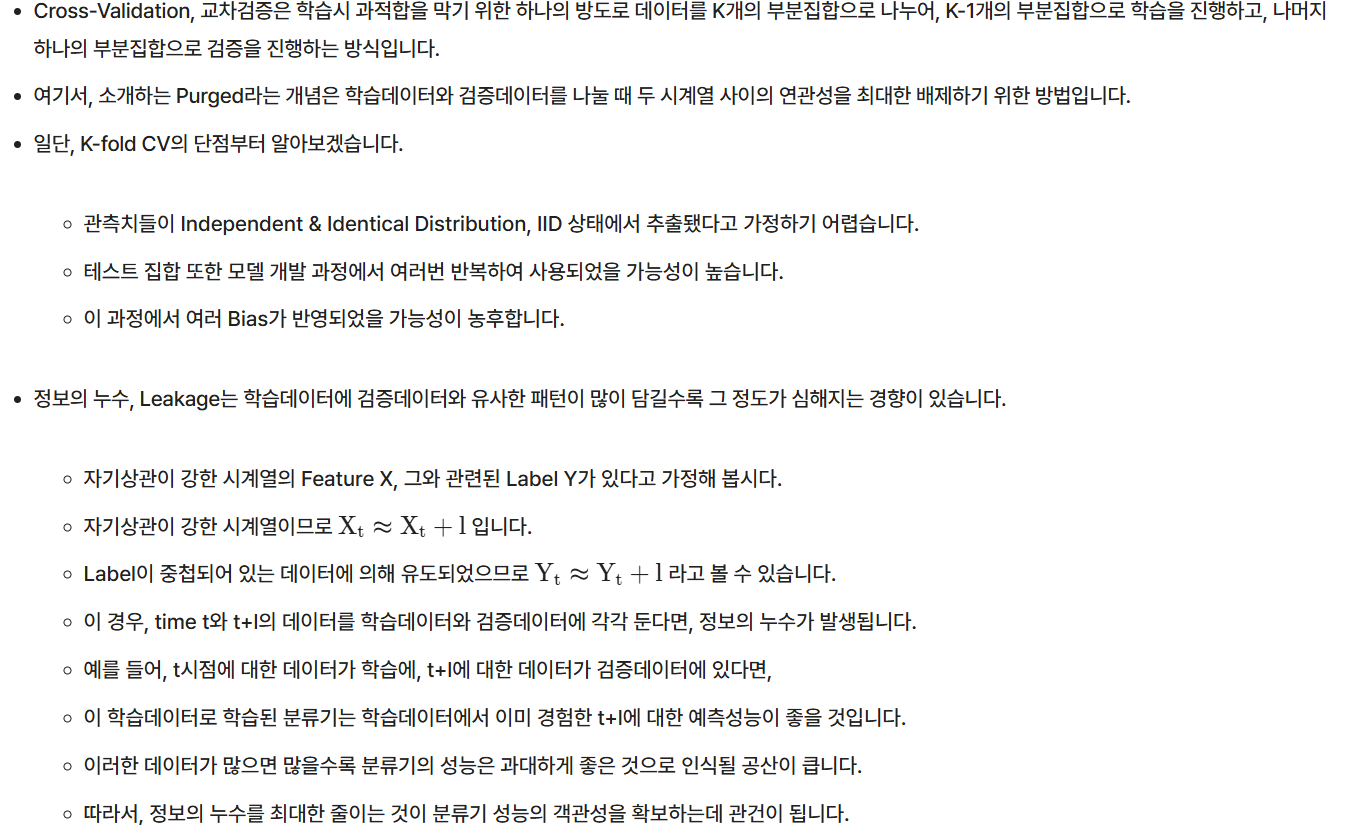
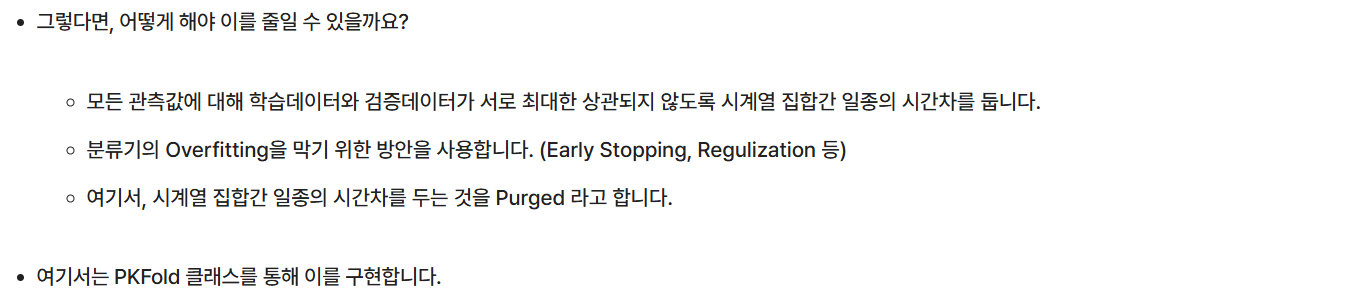

In [21]:
n_cv = 4
t1 = pd.Series(train_y.index.values, index=train_y.index)

cv = PKFold(n_cv, t1, 0)

In [22]:
cv

PKFold(n_splits=4, pct_embargo=0,
    samples_info_sets=time
2018-01-01 00:43:00   2018-01-01 00:43:00
2018-01-01 00:44:00   2018-01-01 00:44:00
2018-01-01 00:45:00   2018-01-01 00:45:00
2018-01-01 00:46:00   2018-01-01 00:46:00
2018-01-01 00:47:00   2018-01-01 00:47:00
                              ...
2018-01-01 11:48:00   201...0   2018-01-01 11:51:00
2018-01-01 11:52:00   2018-01-01 11:52:00
Length: 670, dtype: datetime64[ns])

# 3. Find the best param for bagging(RandomForest) with grid-search

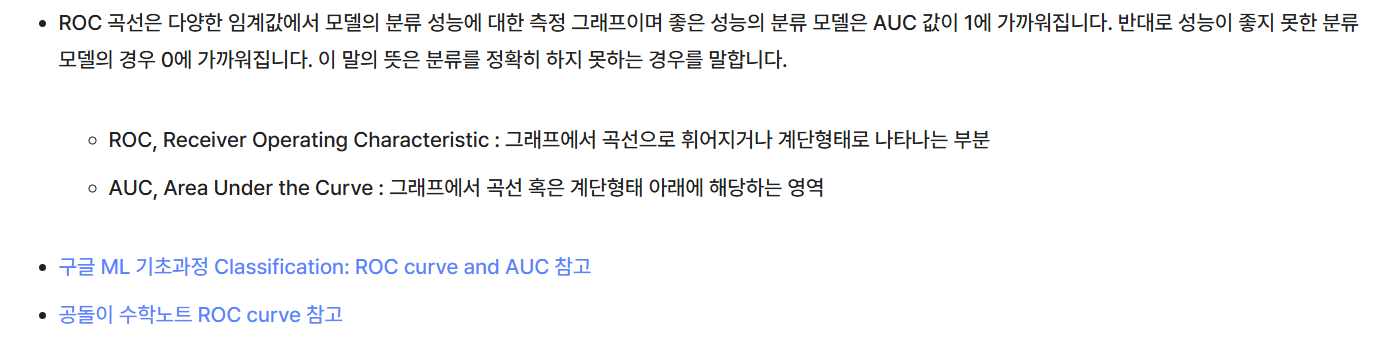

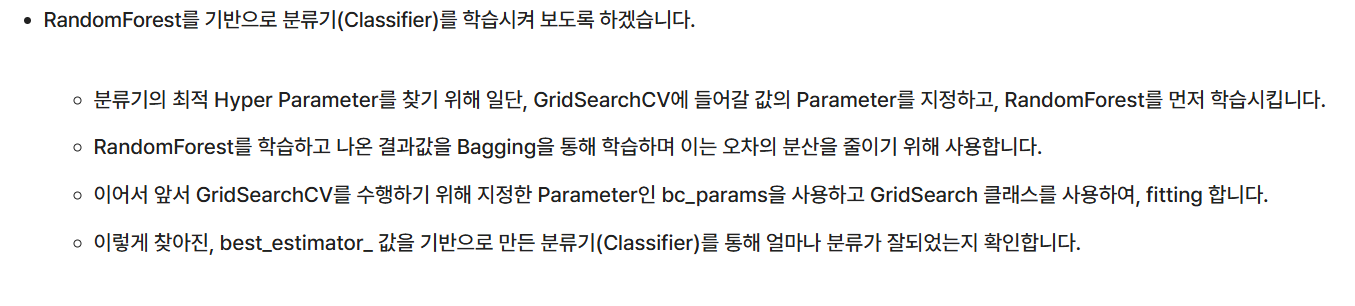

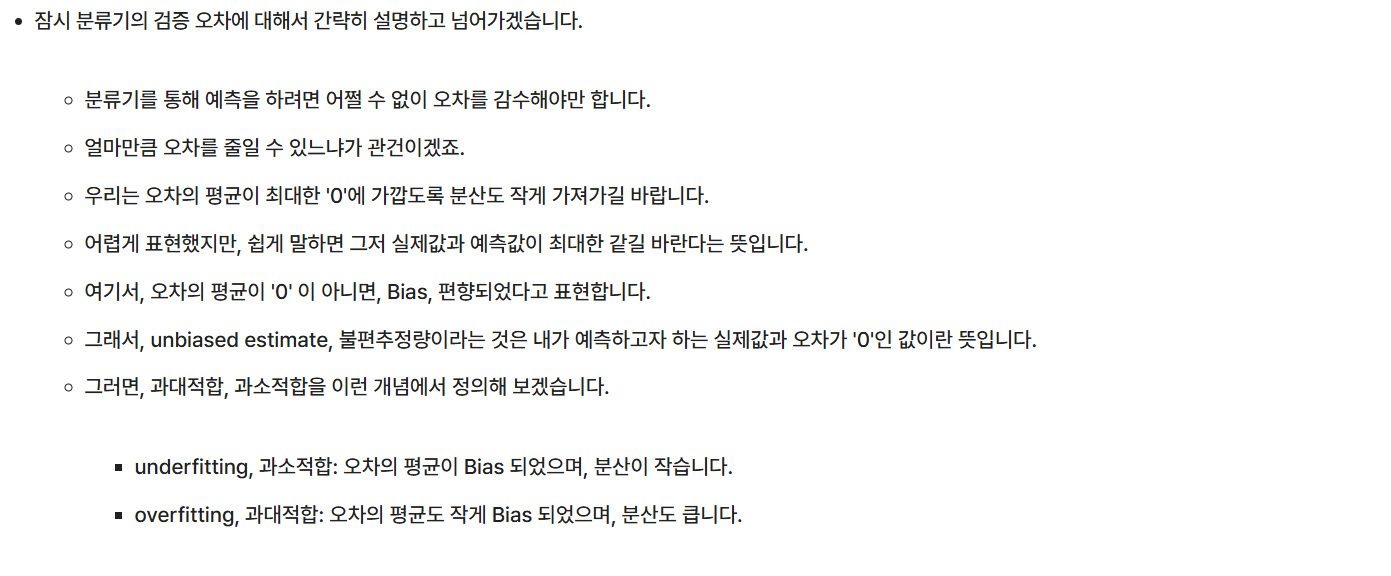

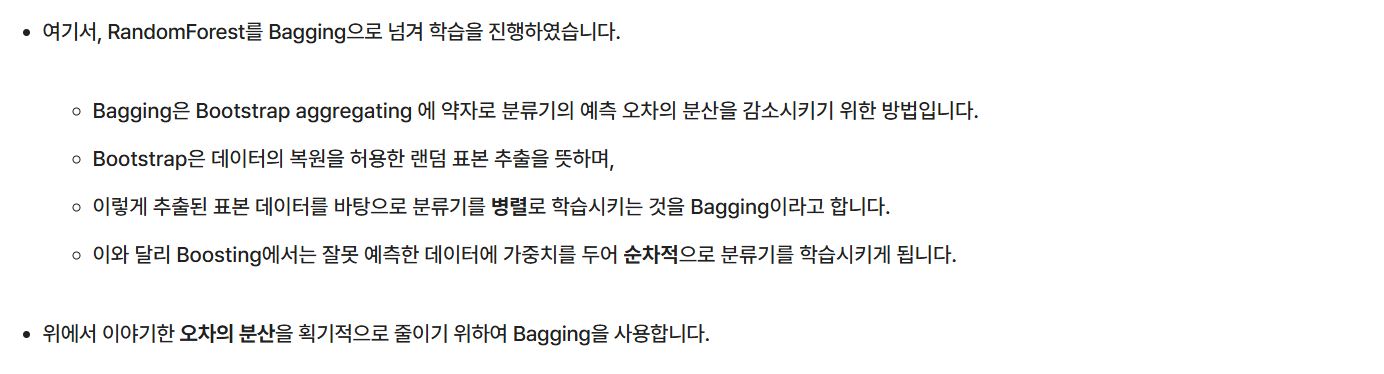

In [ ]:
# 최대 20분정도가 소요됩니다. 시간이 부족하다면 파라미터를 조절하여 진행하세요.
bc_params = {'n_estimators': [5, 10, 20],
             'max_features': [0.5, 0.7],
             'base_estimator__max_depth': [3,5,10,20],
             'base_estimator__max_features': [None, 'auto'],
             'base_estimator__min_samples_leaf': [3, 5, 10],
             'bootstrap_features': [False, True]
            }
             
rfc = RandomForestClassifier(class_weight='balanced')
bag_rfc = BaggingClassifier(rfc)
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)
gs_rfc.fit(train_x, train_y)
gs_rfc_best = gs_rfc.best_estimator_

In [ ]:
gs_rfc_best.fit(train_x, train_y)

In [ ]:
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [ ]:
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

In [ ]:
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')